In [370]:
using DataFrames #for data wrangling
using StatsPlots #for plotting
using Turing #for MCMC
using CSV #CSV import
using Random #data generation (if required)
using Distributions
using LogExpFunctions #for logistic function

Import Data

In [371]:
#this is a local document, but i've also saved a slightly cleaned up version in github with the same "valveTestRaw" title
valveData = CSV.read("./Results of New Valve Tests.csv", DataFrame)

Row,Vendor,Population,Rejected,High Pop,% Over Set,% Over Limit,Set Pressure,Service
,String1,Int64,Int64,Int64,String7,String7,Int64?,String15
1,a,9,2,1,10.00%,4.30%,35,steam
2,b,13,0,0,0.00%,0.00%,missing,air
3,c,85,1,1,13.00%,9.70%,175,steam
4,d,108,21,4,4.50%,1.50%,350,air
5,e,1,0,0,0.00%,0.00%,missing,na
6,f,55,9,2,5.50%,2.50%,400,liquid
7,g,41,5,2,6.70%,3.30%,165,steam
8,h,2,0,0,0.00%,0.00%,missing,air
9,z,40,6,1,24.00%,20.00%,165,steam


Collect Number of Trials & Separate into Service Mediums

In [372]:
steamDF = []
airDF = []
liquidDF = []
airLiqDF = []

steamDF = filter(:Service => ==("steam"), valveData)
airDF = filter(:Service => ==("air"), valveData)
liquidDF = filter(:Service => ==("liquid"), valveData)
airLiqDF = filter(:Service => ==("air/liquid"), valveData)
naDF = filter(:Service => ==("na"), valveData)

n_steam = 0
n_air = 0
n_liquid = 0
n_airLiq = 0
n_na = 0

steamVend = (collect(steamDF[:,1]))
for i in 1:length(steamVend)
    n_steam = steamDF[i,2] +n_steam
end

airVend = (collect(airDF[:,1]))
for i in 1:length(airVend)
    n_air = airDF[i,2] +n_air
end

liquidVend = (collect(liquidDF[:,1]))
for i in 1:length(liquidVend)
    n_liquid = liquidDF[i,2] +n_liquid
end

airLiqVend = (collect(airLiqDF[:,1]))
for i in 1:length(airLiqVend)
    n_airLiq = airLiqDF[i,2] +n_airLiq
end

naVend = (collect(naDF[:,1]))
for i in 1:length(naVend)
    n_na = naDF[i,2]+n_na
end

steamDF

Row,Vendor,Population,Rejected,High Pop,% Over Set,% Over Limit,Set Pressure,Service
,String1,Int64,Int64,Int64,String7,String7,Int64?,String15
1,a,9,2,1,10.00%,4.30%,35,steam
2,c,85,1,1,13.00%,9.70%,175,steam
3,g,41,5,2,6.70%,3.30%,165,steam
4,z,40,6,1,24.00%,20.00%,165,steam
5,k,1,0,0,0.00%,0.00%,missing,steam
6,m,14,7,3,10.00%,3.00%,80,steam


Set Up Model

In [373]:
@model function valveTesting(Vendors, Population, rejects) # highpops serviceMedium)
    #additional functionality can be added to this, especially when considering that the probability of failing (p-1) is the sum of the probability of failing on a low pop (less dangerous) & a high pop (more dangerous)      
    
    
    #hyper prior
        μ_bar ~ Normal(-2, 2) #best first guess is that most valves are unlikely to fail, possibly with large spread
        σ ~ Exponential(1)
    
        μ = Vector{Real}(undef, length(Vendors))

    for i in 1:length(Vendors)
        μ[i] ~ Normal(μ_bar, σ)
    end

    for i in 1:length(Vendors)
        
        #prior
        n = Population[i]
        p = logistic(μ[i]) 
        #distribution of valves failing given fail probability p and n trials
        rejects[i] ~ Binomial(n, p)
    end
end

valveTesting (generic function with 2 methods)

In [374]:
steam_model = valveTesting(steamDF[:,1], steamDF[:,2], steamDF[:,3])

steam_posterior = sample(steam_model, NUTS(), 1000)

Chains MCMC chain (1000×20×1 Array{Float64, 3}):

Iterations        = 501:1:1500
Number of chains  = 1
Samples per chain = 1000
Wall duration     = 2.71 seconds
Compute duration  = 2.71 seconds
parameters        = μ_bar, σ, μ[1], μ[2], μ[3], μ[4], μ[5], μ[6]
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters      mean       std      mcse    ess_bulk   ess_tail      rhat    ⋯
      Symbol   Float64   Float64   Float64     Float64    Float64   Float64    ⋯

       μ_bar   -1.9728    0.7042    0.0277    636.7434   550.7012    1.0057    ⋯
           σ    1.4659    0.6316    0.0383    248.8192   135.5241    0.9998    ⋯
        μ[1]   -1.6300    0.8039    0.0297    766.6669   679.6304    1.0071    ⋯
        μ[2]   -3.8685    0.8270    0.0397    435.3928   468.2086    1.0007    ⋯
        μ[3]   -2.0357    0.45

In [375]:
postDF = DataFrame(steam_posterior)



Row,iteration,chain,μ_bar,σ,μ[1],μ[2],μ[3],μ[4],μ[5],μ[6],lp,n_steps,is_accept,acceptance_rate,log_density,hamiltonian_energy,hamiltonian_energy_error,max_hamiltonian_energy_error,tree_depth,numerical_error,step_size,nom_step_size
,Int64,Int64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,501,1,-1.47329,1.40773,-0.117127,-3.00254,-1.86017,-1.24523,-0.905927,-1.72036,-27.2184,7.0,1.0,0.953034,-27.2184,30.3268,0.105467,-0.501231,3.0,0.0,0.492553,0.492553
2,502,1,-1.98507,0.919679,-2.56463,-3.12734,-1.95947,-1.7566,-2.72779,0.217261,-21.4994,7.0,1.0,0.94295,-21.4994,29.4908,-0.809555,-0.809555,3.0,0.0,0.492553,0.492553
3,503,1,-1.95309,1.12994,-2.94065,-3.69864,-1.46875,-1.7657,-2.14323,0.419706,-22.9041,7.0,1.0,0.896551,-22.9041,26.5367,0.0536452,0.224926,3.0,0.0,0.492553,0.492553
4,504,1,-1.8194,1.07329,-2.77576,-3.83749,-1.43675,-1.91452,-2.37225,0.124179,-22.1865,7.0,1.0,0.995598,-22.1865,23.7956,-0.00017623,-0.203099,2.0,0.0,0.492553,0.492553
5,505,1,-1.88707,1.22493,-0.512976,-3.58918,-2.48389,-1.50013,-0.439486,-1.10585,-23.3321,7.0,1.0,0.88218,-23.3321,25.6228,0.182471,-0.561715,3.0,0.0,0.492553,0.492553
6,506,1,-1.4585,0.911485,-1.27787,-3.45061,-1.09744,-0.728492,-2.8549,-0.628611,-25.8827,7.0,1.0,0.955552,-25.8827,30.1144,0.0183714,0.248815,3.0,0.0,0.492553,0.492553
7,507,1,-2.40543,1.86086,-1.57733,-4.23705,-2.86369,-2.98482,-2.07454,-0.295343,-25.3289,7.0,1.0,0.982701,-25.3289,27.857,0.00500656,-0.507984,3.0,0.0,0.492553,0.492553
8,508,1,-1.56909,2.77682,-0.381135,-3.10089,-1.36313,-2.00992,-7.8772,0.0652498,-28.4389,7.0,1.0,0.814957,-28.4389,34.3846,0.180716,-0.429607,3.0,0.0,0.492553,0.492553
9,509,1,-2.49091,1.15249,-2.22978,-5.12027,-2.70358,-1.43784,0.723768,-0.272066,-28.2516,7.0,1.0,0.932862,-28.2516,32.1495,0.535215,0.535215,3.0,0.0,0.492553,0.492553


Vendor 1 Check (USED FOR DEBUGGING)

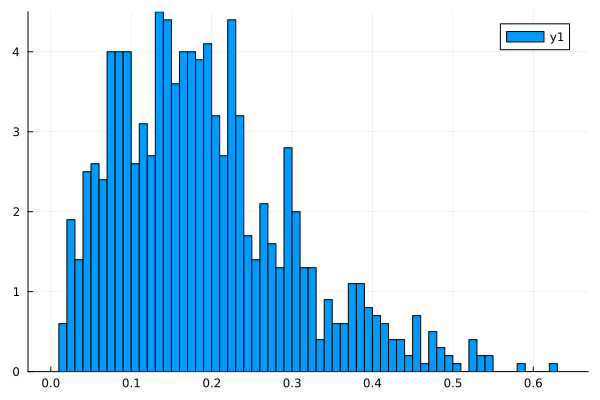

In [376]:
vend1_processed = zeros(nrow(postDF))

for i in 1:nrow(postDF)
    vend1_processed[i] = logistic(postDF[i,5]) #recover probability of a valve from this vendor & service medium failing an initial pop test
end

histogram(vend1_processed, normalize=:pdf, bins=101)

Process Steam Medium Data

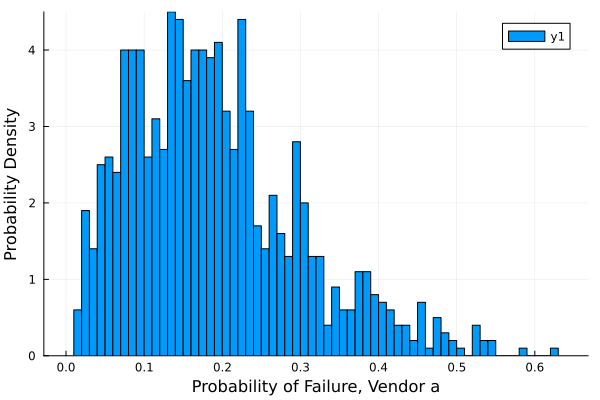

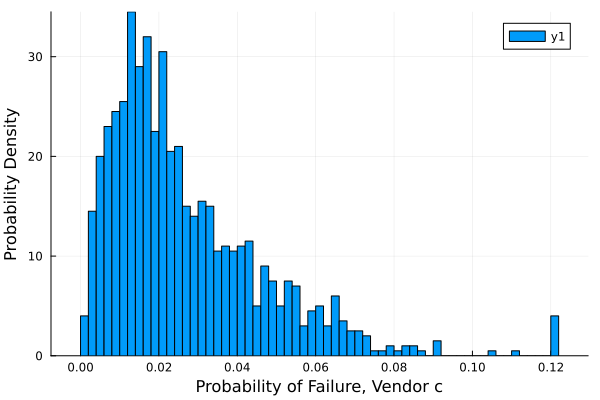

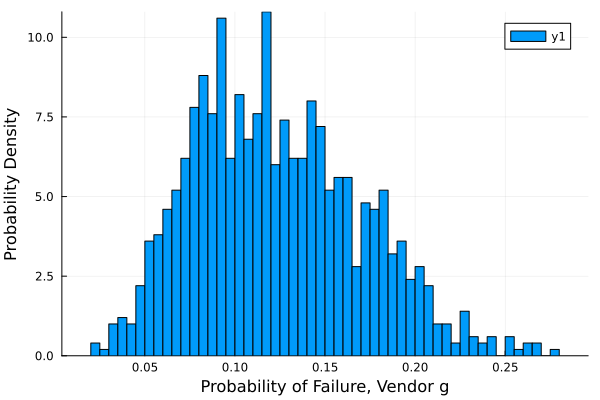

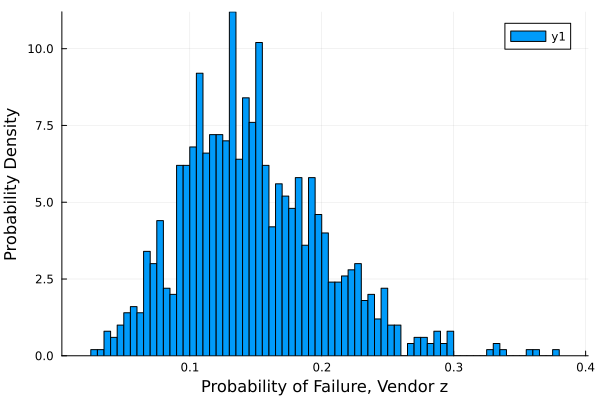

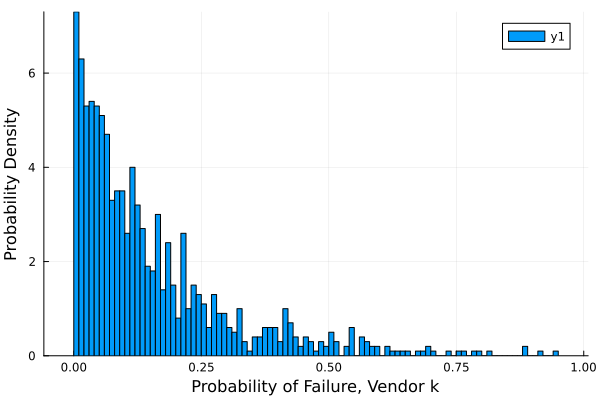

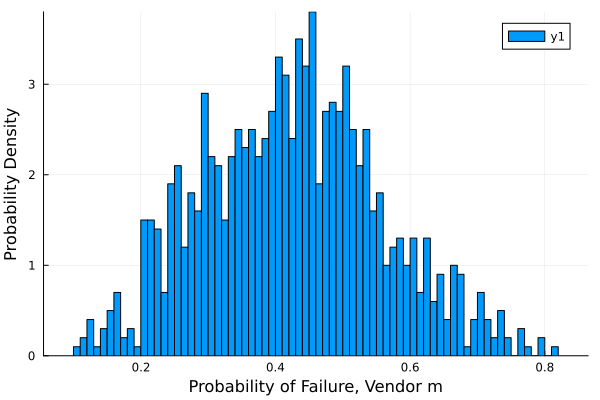

In [377]:
#gather all posterior data into an array, with each column representing a vendor's data
#also make an array of plots for each
steam_processed = zeros(nrow(postDF), nrow(steamDF))
steam_plots = Array{Plots.Plot{Plots.GRBackend},1}()

#set array values to match calculated μ values from MCMC
#post-process with logistic function to recover probability of valve failure
for i in 1:nrow(steamDF)
    for j in 1:nrow(postDF)
        steam_processed[j,i] = logistic(postDF[j, "μ[$i]"])
    end
    #plotter is an intermediate value to gather plot data & incorporate into plot array
    plotter = histogram(steam_processed[:,i], xlab = "Probability of Failure, Vendor " * steamDF[i, 1], ylab = "Probability Density", normalize=:pdf, bins=101)
    push!(steam_plots, plotter)
end
#plot all probability plots for the steam medium, grouped by vendor
for z in 1:length(steam_plots)
    display(plot(steam_plots[z]))
end